In [547]:
# Imports
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE  # For oversampling the minority class
from tkinter import Tk, filedialog
from sklearn.base import BaseEstimator
from matplotlib.colors import ListedColormap

# Initialize output path as None
output_path = None

In [548]:
def screen_data(df, features, target): # data screening function
    """
    Creates a subset of the desired features and applies listwise deletion (deletes rows if any feature is missing).
    
    Parameters:
        df (DataFrame): Original DataFrame.
        features (list): List of feature column names to retain.
        target (str): optional one off parameter.
    
    Returns:
        subset (DataFrame): Processed DataFrame after listwise deletion.
    """
    if target is not None:
        subset = df[features + [target]].dropna(axis=0, how='any')
    else:
        subset = df[features].dropna(axis=0, how='any')
        
    
    if subset.empty:
        print(f"Dataset is empty.")
        return None,

    return subset

In [549]:
def get_marker_map(subset, target):
    """
    Generate a mapping from unique categorical values to specific marker types for plotting.

    This function ensures that the dataset has exactly three unique values in the specified target column
    and maps each unique value to a distinct marker type.

    Parameters:
        subset (pandas.DataFrame): The subset of the dataset to be used for the mapping.
        target (str): The column name in the dataset whose unique values will be mapped to markers.

    Returns:
        dict: A dictionary where keys are the unique values from the target column and values are marker strings.
    
    Raises:
        ValueError: If the target column does not have exactly three unique values.

    Example:
        subset
        3-tier rank  feature1
        0           A        1.0
        1           B        2.0
        2           C        3.0
        3           A        4.0
        4           B        5.0
        target = '3-tier rank'
        get_marker_map(subset, target)
        {'A': 'o', 'B': 's', 'C': '^'}
    """
    # Check that there are exactly three unique '3-tier rank' values
    unique_rates = subset[target].unique()
    assert len(unique_rates) == 3, "The dataset must have exactly 3 unique '3-tier rank' values"

    # Define a list of markers for the three unique degradation rates
    markers = ['o', 's', '^']
    marker_map = {rate: markers[i] for i, rate in enumerate(unique_rates)}
    return marker_map

In [550]:
def select_output_directory():# Get the output directory from user input
    """
    This function prompts the user to select an output directory using a graphical file dialog.

    Returns:
        str: The path of the selected output directory.

    Raises:
        Exception: If no directory is selected by the user.
    """
    # Initialize the Tkinter root window
    root = Tk()

    # Lift the root window to the top
    root.lift()
    root.attributes('-topmost', True)
    
    # Open a directory selection dialog and store the selected directory
    directory = filedialog.askdirectory(title="Select Output Directory", parent=root)

    # Withdraw the root window after the dialog is closed
    root.withdraw()

    # Check if a directory was selected
    if directory:
        return directory
    else:
        raise Exception("No directory selected.")  

In [551]:
def save_location_pre_processing_folder(output_path):
    """
    Prepares the output directory and file for correlation significance results.

    Parameters:
        output_path (str, optional): The base directory where results will be saved. Defaults to None.

    Returns:
        tuple: A tuple containing the output directory path and the output file path.
    """
    # create output path and file 
    if output_path is None:
        output_path = select_output_directory()
        output_path = f"{output_path}/linearSVMplots"

    return output_path

In [552]:

# data set loading, feature definitions,alpha for significance test

# Load the Excel file
df = pd.read_excel('Project Dataset.xlsx', sheet_name='data', engine='openpyxl')

# defining the desired weight loss reporting methods for screening
wtlossreporting= [['BOD (% /day)','BOD'], ['wt. loss (% /day)','WT LOSS']]
         
# defining significance level 
alpha = 0.1

# renaming features for clarity
df = df.rename(columns={'BOD (% day-1)': 'BOD (% /day)',
                        'wt. loss (% day-1)':'wt. loss (% /day)',                        
                        'den (g mL-1)':'den (g/mL)',
                        "% cryst": "% crystallinity", 
                        "enthalpy (J g-1)": "enthalpy (J/g)", 
                        "LogP(SA)-1 (Å-2)": "LogP/(SA)", 
                        "Mw (kg mol-1)": "Mw (kg/mol)",
                        "Mn (kg mol-1)": "Mn (kg/mol)",
                        '3-tier rank': 'Degradation Rate'
                        })

# grouping feature for plots
target = 'Degradation Rate'

# Select the features and target
features = ["% crystallinity", 
            "enthalpy (J/g)", 
            "Tg (°C)", 
            "LogP/(SA)", 
            "Mw (kg/mol)"
            ]

target = 'Degradation Rate'

# cant use special characters in the save files so now it maps to an acceptable name
save_name_mapping = {'den (g/mL)':'density',
                    'total sp3 C':'total sp3 C', 
                    '% sp3 C':'percent sp3 C', 
                    'LogP/(SA)': 'LogPSA',
                    'Mw (kg/mol)': 'MW', 
                    'Mn (kg/mol)': 'Mn', 
                    'Mw/Mn':'Ratio MwMn',
                    'Tg (°C)':'Tg',
                    'Tm (°C)':'Tm',
                    '% crystallinity':'percent crystallinity',
                    'enthalpy (J/g)':'enthalpy',
                    '(Tw-Tg)/(LogP/SA)':'TWTW_LogPSA'
                    }
# C hyperparameters tested 
C = [0.1, 1, 5, 10, 20, 50, 75, 100, 200, 500]


In [553]:
def plot_decision_boundary(X_train, y_train, X_test, y_test, model, feature_x, feature_y, title, train_accuracy, test_accuracy, best_C, label_encoder, marker_map, output_path, save_name_mapping):
    """
    Plots the decision boundary of a given model for both training and test datasets.
    
    Parameters:
    - X_train: numpy array, feature set for training data.
    - y_train: numpy array, target labels for training data.
    - X_test: numpy array, feature set for test data.
    - y_test: numpy array, target labels for test data.
    - model: the trained model used to predict.
    - feature_x: str, name of the x-axis feature.
    - feature_y: str, name of the y-axis feature.
    - title: str, title for the plot.
    - train_accuracy: float, accuracy of the model on the training set.
    - test_accuracy: float, accuracy of the model on the test set.
    - best_C: float, the best C value for the SVM model.
    - label_encoder: LabelEncoder object, used to decode the target labels.
    - marker_map: dict, mapping from target labels to marker styles.
    """
    
    y_train_labels = label_encoder.inverse_transform(y_train)
    df_features = pd.DataFrame(X_train, columns=[feature_x, feature_y])
    df_target = pd.DataFrame(y_train_labels, columns=['Degradation Rate'])
    df = pd.concat([df_features, df_target], axis=1)
    
    x_axis = df.columns[0]
    y_axis = df.columns[1]

    x_min, x_max = np.min([X_train[:, 0].min(), X_test[:, 0].min()]) - 1, np.max([X_train[:, 0].max(), X_test[:, 0].max()]) + 1
    y_min, y_max = np.min([X_train[:, 1].min(), X_test[:, 1].min()]) - 1, np.max([X_train[:, 1].max(), X_test[:, 1].max()]) + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    unique_labels = np.unique(y_train)
    colors = plt.cm.coolwarm(np.linspace(0, 1, len(unique_labels)))
    cmap = ListedColormap(colors)

    color_map = {label: colors[i] for i, label in enumerate(unique_labels)}

    axes[0].contourf(xx, yy, Z, alpha=0.5, cmap=cmap)
    
    for rate, group in df.groupby("Degradation Rate"):
        marker = marker_map[rate]
        color = color_map[label_encoder.transform([rate])[0]]
        axes[0].scatter(group[x_axis], group[y_axis], label=rate, marker=marker, color=color, edgecolor='k', s=50, alpha=0.7)
    
    axes[0].set_title(f"{title} for Training Set\nAccuracy: {train_accuracy:.2f}, C: {best_C}")
    axes[0].set_xlabel(feature_x)
    axes[0].set_ylabel(feature_y)
    axes[0].legend(title="Degradation Rate")

    y_test_labels = label_encoder.inverse_transform(y_test)
    df_test_features = pd.DataFrame(X_test, columns=[feature_x, feature_y])
    df_test_target = pd.DataFrame(y_test_labels, columns=['Degradation Rate'])
    df_test = pd.concat([df_test_features, df_test_target], axis=1)

    axes[1].contourf(xx, yy, Z, alpha=0.5, cmap=cmap)
    
    for rate, group in df_test.groupby("Degradation Rate"):
        marker = marker_map[rate]
        color = color_map[label_encoder.transform([rate])[0]]
        axes[1].scatter(group[x_axis], group[y_axis], label=rate, marker=marker, color=color, edgecolor='k', s=50, alpha=0.7)

    axes[1].set_title(f"{title} for Test Set\nAccuracy: {test_accuracy:.2f}, C: {best_C}")
    axes[1].set_xlabel(feature_x)
    axes[1].set_ylabel(feature_y)
    axes[1].legend(title="Degradation Rate")

    plt.tight_layout()
        
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    
    # Save the figure to the specified folder
    save_name_x = save_name_mapping[x_axis]
    save_name_y = save_name_mapping[y_axis]
    plt.savefig(os.path.join(output_path, f"linear_SVM_plot_{save_name_x}_vs_{save_name_y}.png"))
    plt.show()

In [554]:
def evaluate_feature_pairs(df, features, target, output_path, save_name_mapping, n_splits=3, param_grid={'C': C}):
    """
    Evaluates all pairs of features in a DataFrame using an SVM model with cross-validation,
    and plots the decision boundary for each pair.
    
    Parameters:
    - df: DataFrame, the dataset containing features and target.
    - features: list of str, the feature columns to consider for pair-wise evaluation.
    - target: str, the target column name.
    - n_splits: int, number of splits for K-Fold cross-validation.
    - param_grid: dict, the grid of parameters for GridSearchCV.
    
    Returns:
    - results: list of tuples, each containing feature pair evaluation metrics and model details.
    """
    results = []
    marker_map = get_marker_map(df, target)  # Creating markers for plotting target
    
    # Encode the target labels
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(df[target].values)
    
    # Handle class imbalance using SMOTE
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(df[features].values, y)

    # Standardize features for SVM
    scaler = StandardScaler()
    X_resampled = scaler.fit_transform(X_resampled)
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for i in range(len(features)):
        for j in range(i + 1, len(features)):
            feature_x = features[i]
            feature_y = features[j]
            
            # Extract feature pairs
            X_pair = X_resampled[:, [i, j]]
            
            # Split data into training and test sets
            X_train, X_test, y_train, y_test = train_test_split(X_pair, y_resampled, test_size=0.3, random_state=42)
            
            # Initialize the SVM model
            svc = SVC(kernel='linear')
            
            # Use GridSearchCV with k-fold cross-validation
            grid_search = GridSearchCV(svc, param_grid, cv=kf)
            grid_search.fit(X_train, y_train)
            
            # Retrieve the best model and its scores
            best_model = grid_search.best_estimator_
            best_params = grid_search.best_params_
            
            # Calculate training and test accuracy
            train_accuracy = best_model.score(X_train, y_train)
            test_accuracy = best_model.score(X_test, y_test)
            
            # Save results
            results.append((feature_x, feature_y, train_accuracy, test_accuracy, grid_search.best_score_, best_model, best_params['C']))
            
            # Plot decision boundary
            plot_decision_boundary(X_train, y_train, X_test, y_test, best_model, feature_x, feature_y,
                                   f"Decision Boundary: {feature_x} vs {feature_y}", train_accuracy, test_accuracy, best_params['C'], label_encoder, marker_map, output_path,save_name_mapping)

    return results



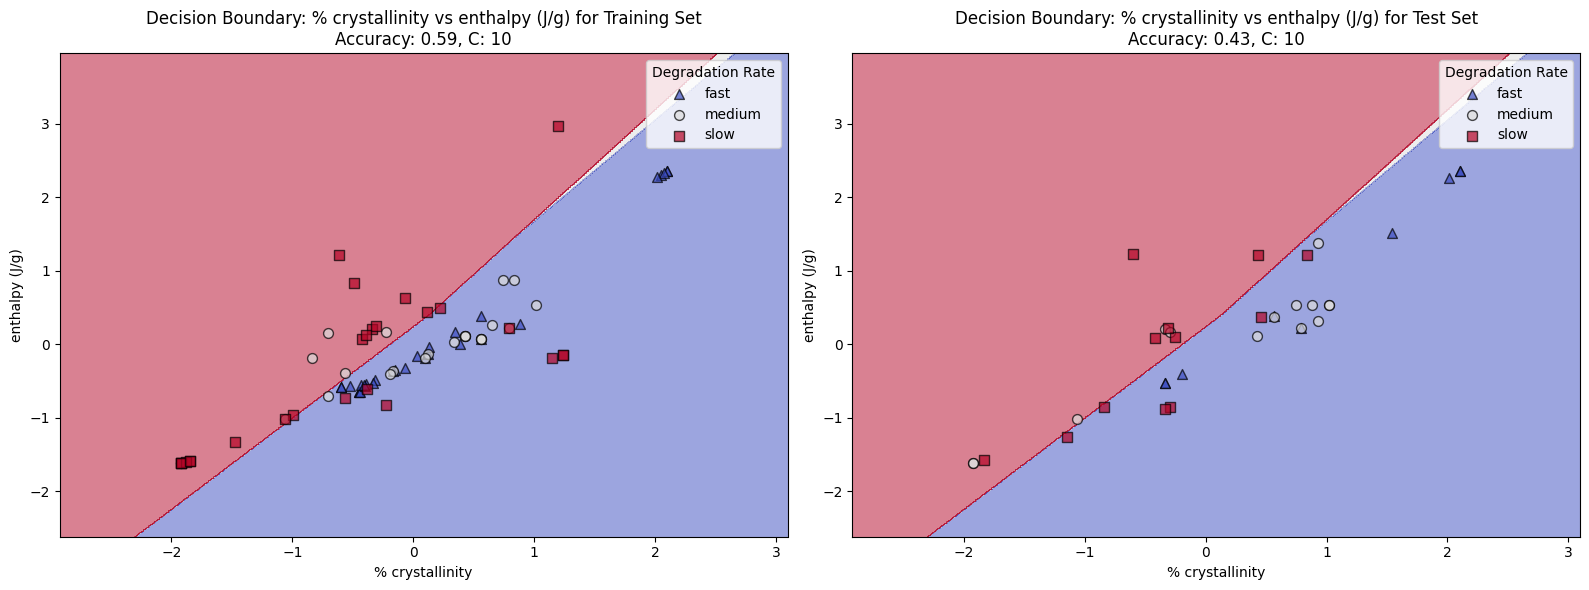

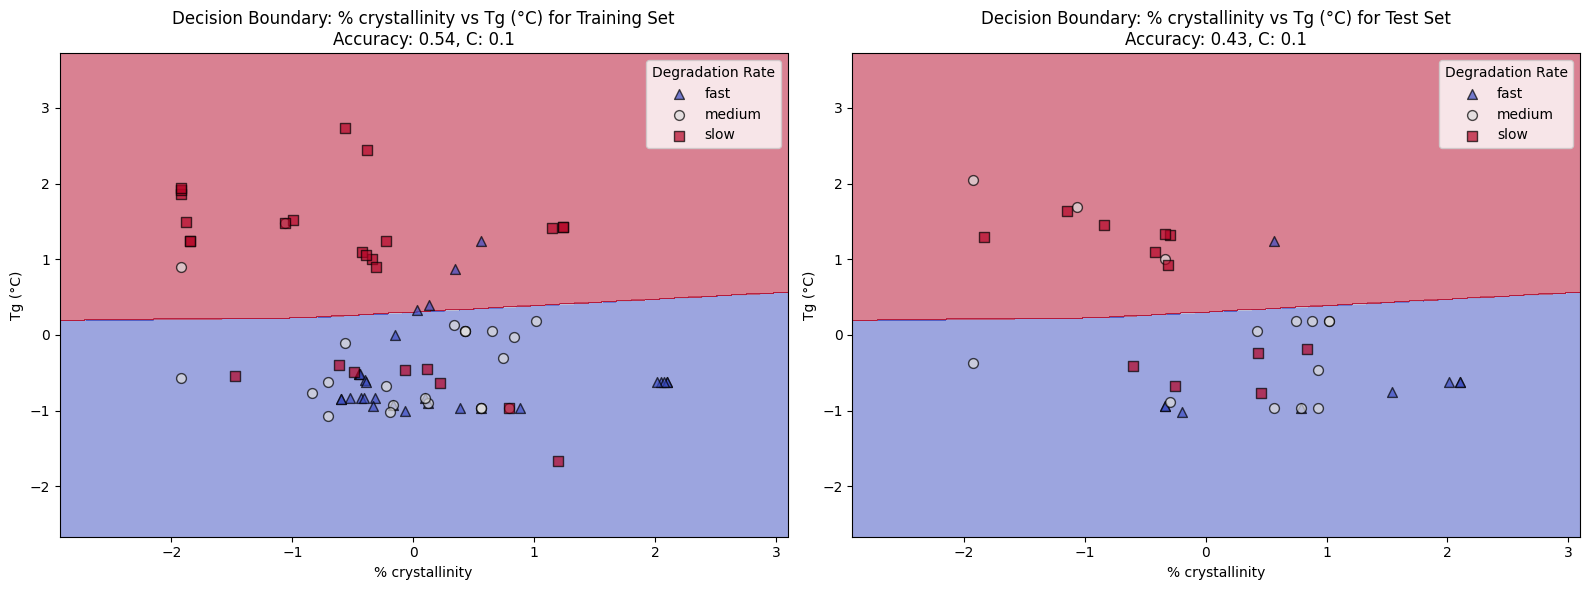

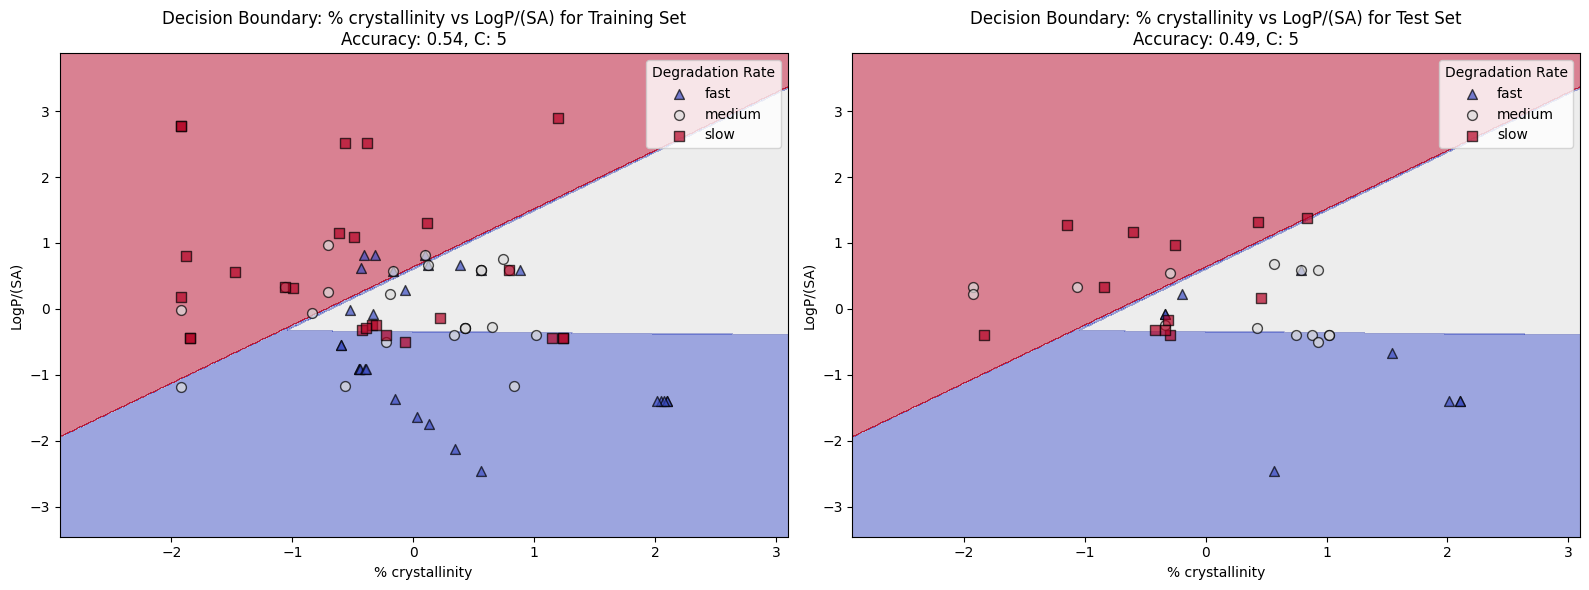

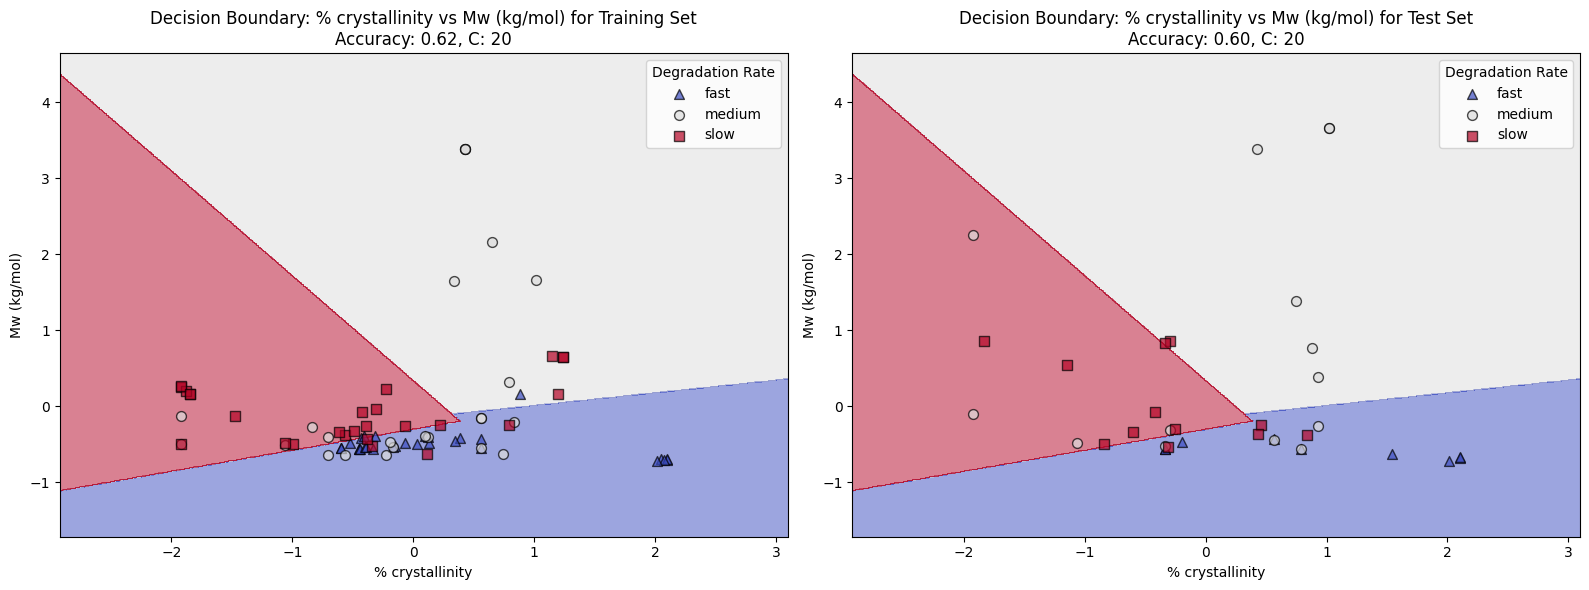

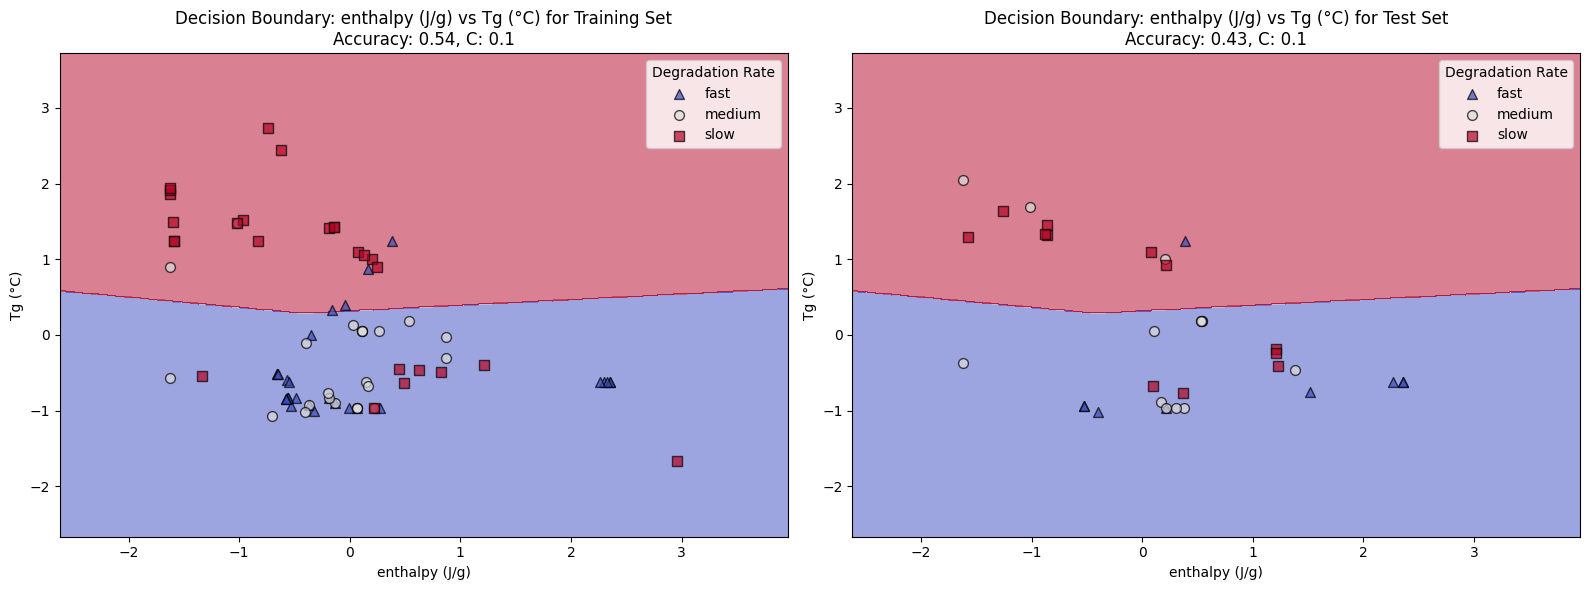

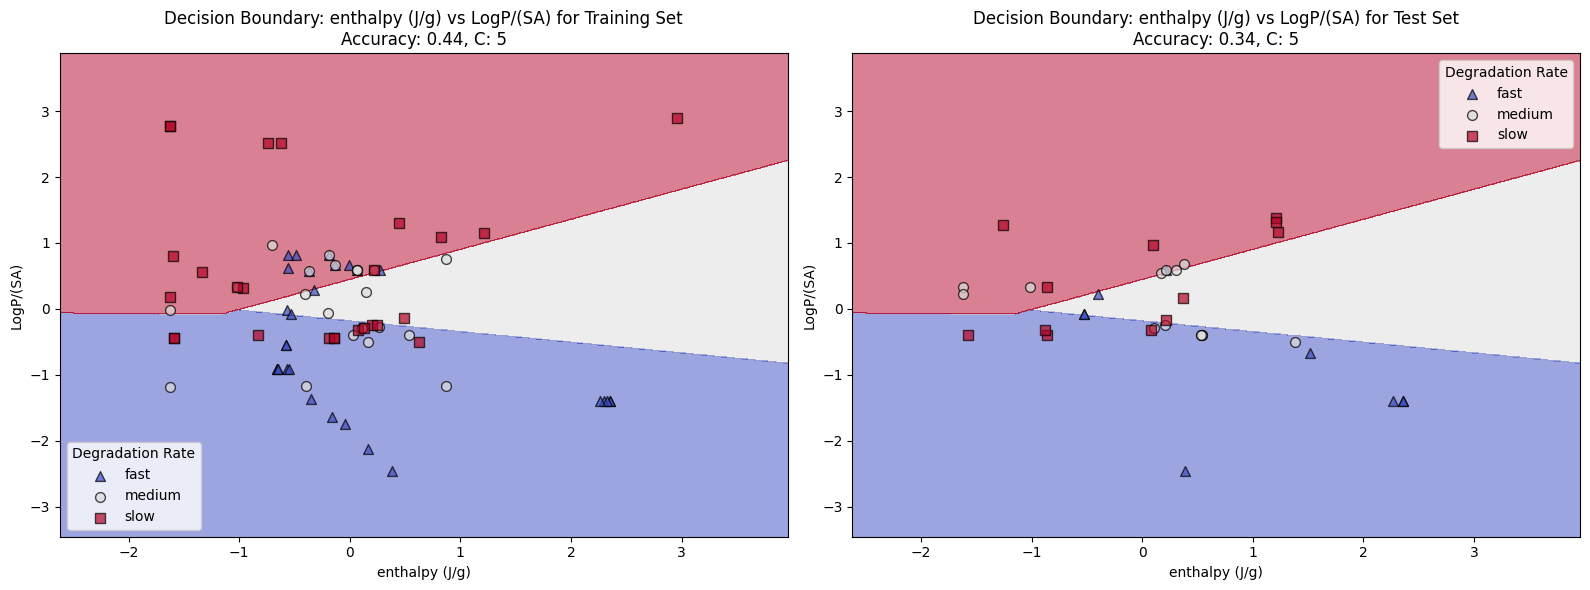

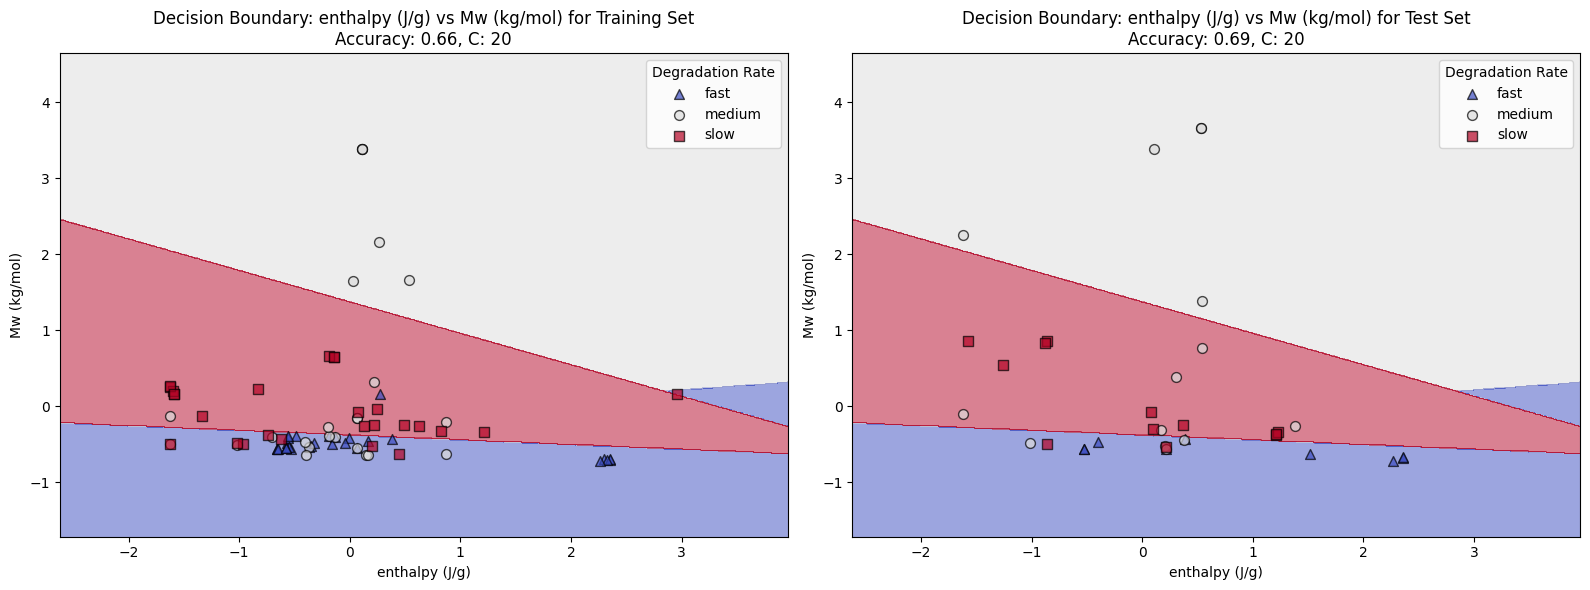

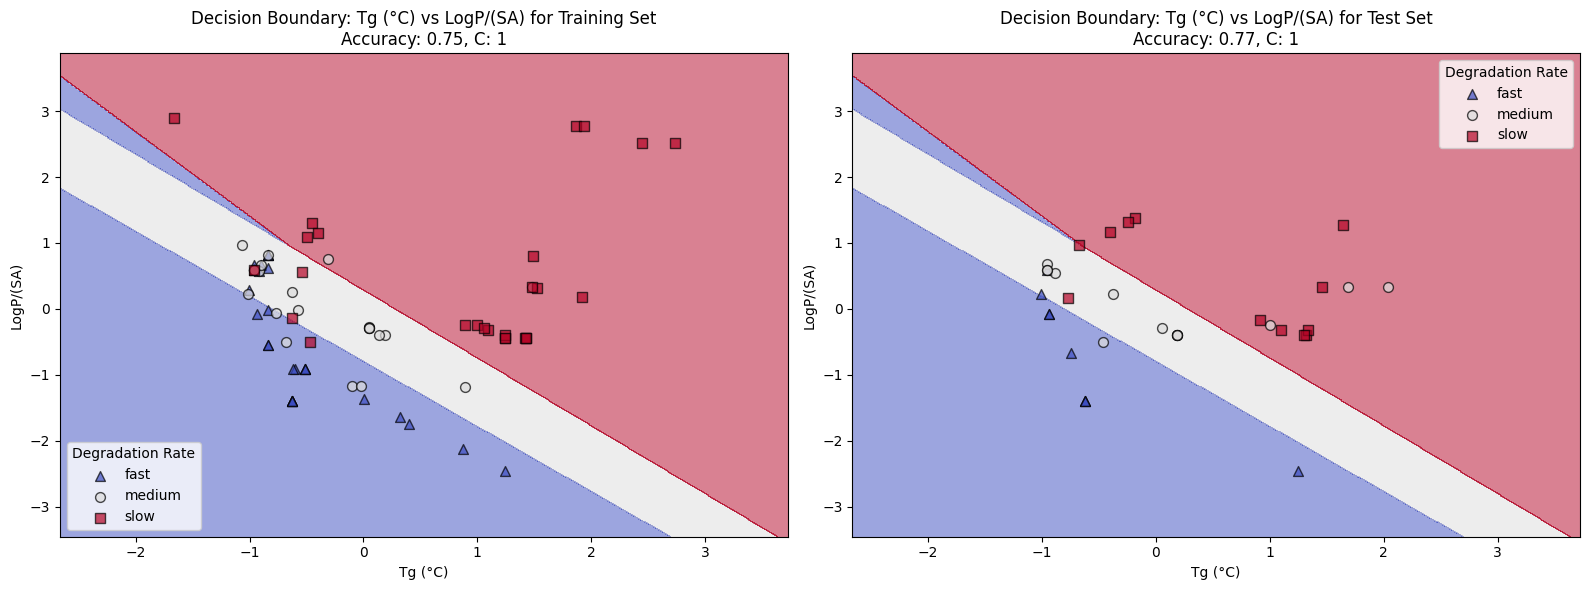

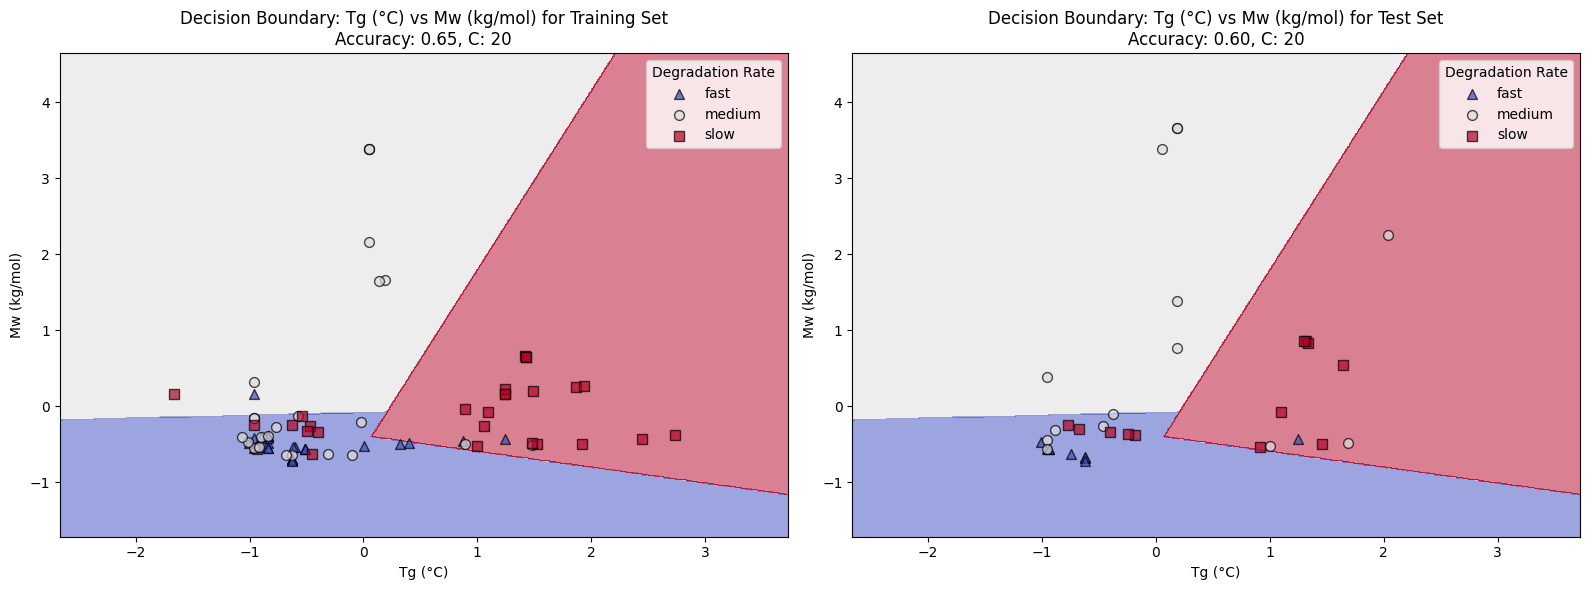

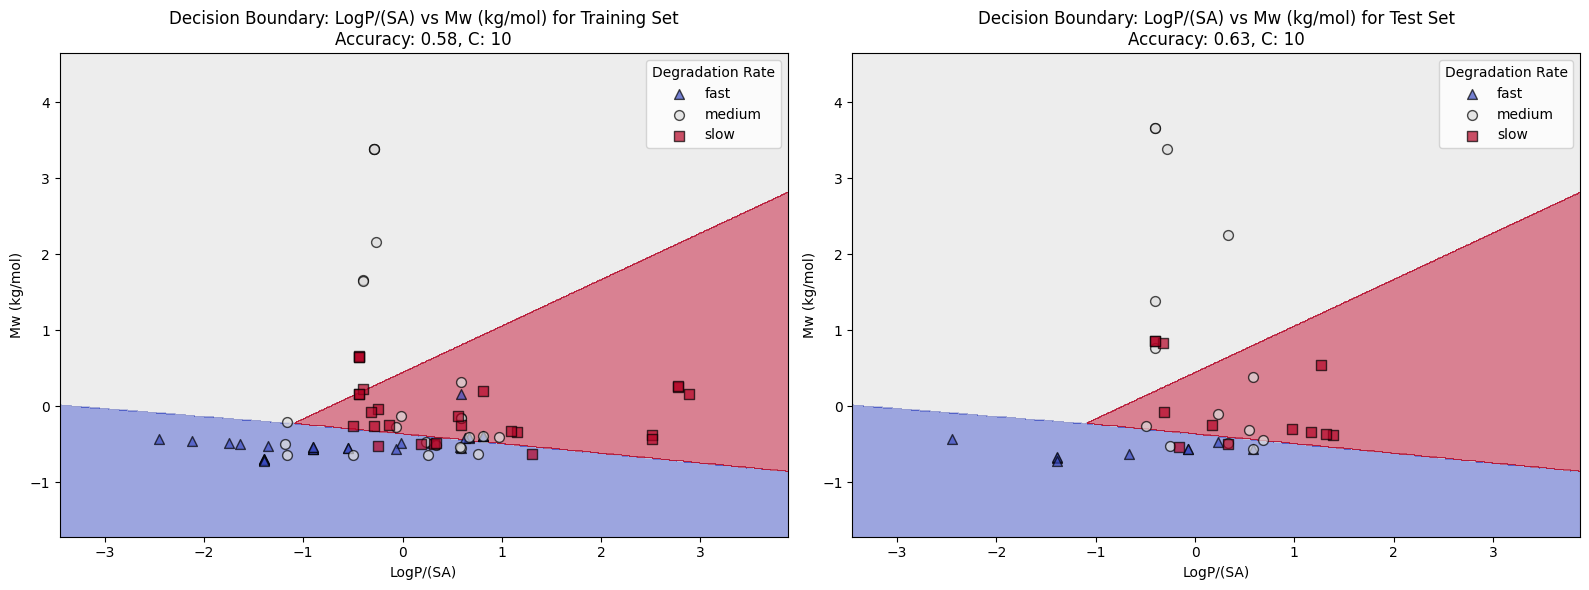

Evaluation Results:
C hyperparameters tested: 
  [0.1, 1, 5, 10, 20, 50, 75, 100, 200, 500]
Features: % crystallinity vs enthalpy (J/g)
Training Accuracy: 0.59
Testing Accuracy: 0.43
Best C: 10.00
----------------------------------------
Features: % crystallinity vs Tg (°C)
Training Accuracy: 0.54
Testing Accuracy: 0.43
Best C: 0.10
----------------------------------------
Features: % crystallinity vs LogP/(SA)
Training Accuracy: 0.54
Testing Accuracy: 0.49
Best C: 5.00
----------------------------------------
Features: % crystallinity vs Mw (kg/mol)
Training Accuracy: 0.62
Testing Accuracy: 0.60
Best C: 20.00
----------------------------------------
Features: enthalpy (J/g) vs Tg (°C)
Training Accuracy: 0.54
Testing Accuracy: 0.43
Best C: 0.10
----------------------------------------
Features: enthalpy (J/g) vs LogP/(SA)
Training Accuracy: 0.44
Testing Accuracy: 0.34
Best C: 5.00
----------------------------------------
Features: enthalpy (J/g) vs Mw (kg/mol)
Training Accuracy: 0.66
T

In [555]:
# Get output path from user input
output_path = save_location_pre_processing_folder(output_path)

# Perform data screening
data = screen_data(df, features, target)

# Evaluate feature pairs and visualize
results = evaluate_feature_pairs(data, features, target, output_path, save_name_mapping)

# Display results
print("Evaluation Results:")
print("C hyperparameters tested: \n ", C )
print("=" * 40)

for feature_x, feature_y, train_acc, test_acc, best_score, best_model, best_C in results:
    print(f"Features: {feature_x} vs {feature_y}")
    print(f"Training Accuracy: {train_acc:.2f}")
    print(f"Testing Accuracy: {test_acc:.2f}")
    print(f"Best C: {best_C:.2f}")
    print("-" * 40)